In [1]:
import os
import numpy as np
from numpy import load
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from helpers import plots

import keras
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

try:
    from tensorflow.python.util import module_wrapper as deprecation
except ImportError:
    from tensorflow.python.util import deprecation_wrapper as deprecation
deprecation._PER_MODULE_WARNING_LIMIT = 0

Using TensorFlow backend.


In [2]:
batch_size = 64
epochs = 15
IMG_HEIGHT = 240
IMG_WIDTH = 240

model_path = '../models/hggvgg_model_7.h5'


In [3]:
model = Sequential([
        Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3), name='conv_a'),
        MaxPooling2D(name='max_a'),
        BatchNormalization(name='batch_norm'),
        Dropout(0.2,name='drop_a'),
        Conv2D(32, 3, padding='same', activation='relu', name='conv_b'),
        MaxPooling2D(name='max_b'),
        Conv2D(64, 3, padding='same', activation='relu', name='conv_c'),
        MaxPooling2D(name='max_c'),
        Conv2D(128, 3, padding='same', activation='relu', name='conv_d'),
        MaxPooling2D(name='max_d'),
        Dropout(0.2, name='drop_c'),
        Flatten(name='flat_a'),
        Dense(64, activation='relu', name='dense_a'),
        Dense(2, activation="softmax", name='dense_b')
    ])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


#### Load from numpy

In [4]:
# X_train_dir = '../data/np/X_train.npy'
# y_train_dir = '../data/np/y_train.npy'
# X_valid_dir = '../data/np/X_test.npy'
# y_valid_dir = '../data/np/y_test.npy'

# train_image_generator = ImageDataGenerator(rotation_range=30,
#                                            width_shift_range=.1,
#                                            height_shift_range=.1,
#                                            horizontal_flip=True,
#                                            vertical_flip=True
#                                           )
# validation_image_generator = ImageDataGenerator()

In [5]:
# X_train = load(X_train_dir)
# y_train = load(y_train_dir)
# X_test = load(X_valid_dir)
# y_test = load(y_valid_dir)

# y_train = np.array([[0,1] if x ==1 else [1,0] for x in y_train])
# y_test = np.array([[0,1] if x ==1 else [1,0] for x in y_test])

# train_data_gen = train_image_generator.flow(X_train, y_train, batch_size=batch_size,
#                                                            shuffle=True)

# val_data_gen = validation_image_generator.flow(X_test, y_test, batch_size=batch_size,
#                                                            shuffle=True)

#### Load from directory

In [6]:
train_dir = '../data/train/t2_t1ce_flair_hl/'
val_dir = '../data/valid/t2_t1ce_flair_hl/'

train_image_generator = ImageDataGenerator(rescale=1./255, 
                                           rotation_range=45,
                                           horizontal_flip=True,
                                           vertical_flip=True)
validation_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           classes=['LGG', 'HGG'],
                                                           color_mode="rgb",
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='sparse')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=val_dir,
                                                           shuffle=True,
                                                           classes=['LGG', 'HGG'],
                                                           color_mode="rgb",
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='sparse')

Found 1659 images belonging to 2 classes.
Found 428 images belonging to 2 classes.


In [7]:
sample_training_images, l = next(train_data_gen)
sample_training_images.shape

(64, 240, 240, 3)

[0. 0. 0. 0. 0.]


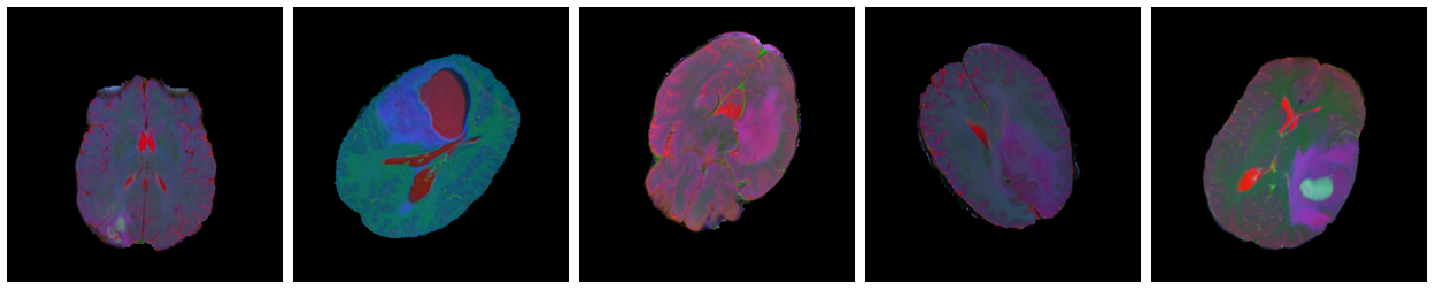

In [8]:
print(l[:5])
plots.plot_rgb_images(sample_training_images[:5])

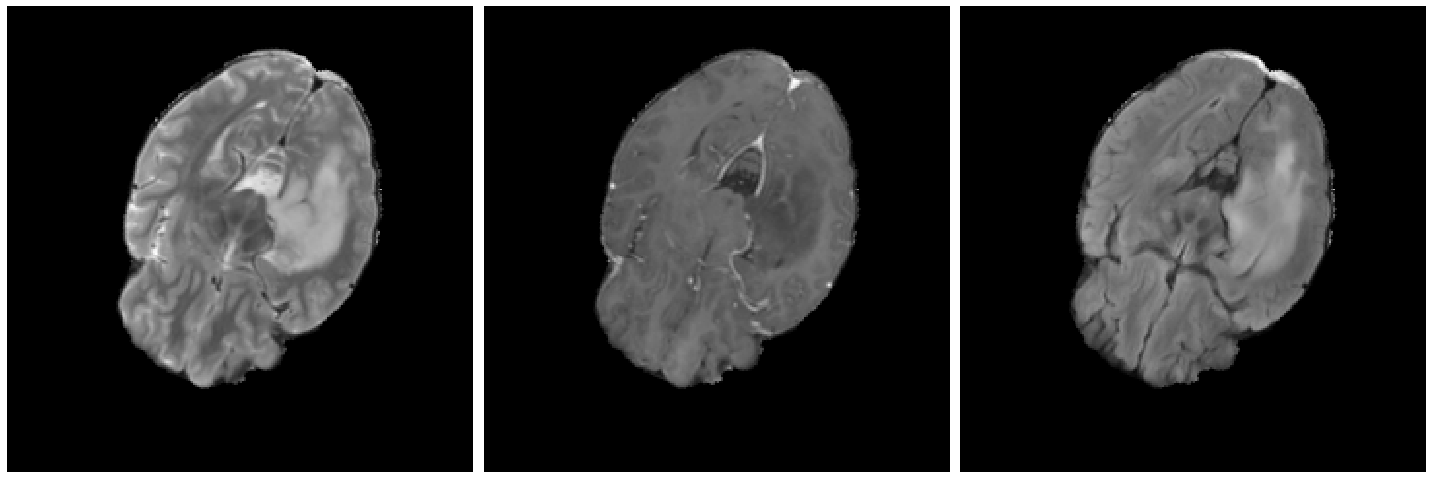

In [9]:
plots.plot_rgb_decomposition(sample_training_images[2])

In [10]:
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=adam,
             loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_a (Conv2D)              (None, 240, 240, 16)      448       
_________________________________________________________________
max_a (MaxPooling2D)         (None, 120, 120, 16)      0         
_________________________________________________________________
batch_norm (BatchNormalizati (None, 120, 120, 16)      64        
_________________________________________________________________
drop_a (Dropout)             (None, 120, 120, 16)      0         
_________________________________________________________________
conv_b (Conv2D)              (None, 120, 120, 32)      4640      
_________________________________________________________________
max_b (MaxPooling2D)         (None, 60, 60, 32)        0         
_________________________________________________________________
conv_c (Conv2D)              (None, 60, 60, 64)        18496     
__________

In [12]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=1659 // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=428 // batch_size
)

# Save the model
model.save(model_path);

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/15
25/25 [==============================] - 16s 660ms/step - loss: 0.8043 - acc: 0.5151 - val_loss: 0.6776 - val_acc: 0.5260
Epoch 2/15
25/25 [==============================] - 15s 583ms/step - loss: 0.6411 - acc: 0.6350 - val_loss: 0.6120 - val_acc: 0.7253
Epoch 3/15
25/25 [==============================] - 16s 639ms/step - loss: 0.6073 - acc: 0.6703 - val_loss: 0.5741 - val_acc: 0.7033
Epoch 4/15
25/25 [==============================] - 16s 639ms/step - loss: 0.5238 - acc: 0.7383 - val_loss: 0.5838 - val_acc: 0.7170
Epoch 5/15
25/25 [==============================] - 16s 621ms/step - loss: 0.4673 - acc: 0.7822 - val_loss: 0.5410 - val_acc: 0.7390
Epoch 6/15
25/25 [==============================] - 17s 661ms/step - loss: 0.4356 - acc: 0.7932 - val_loss: 0.5360 - val_acc: 0.7225
Epoch 7/15
25/25 [==============================] - 16s 653ms/step - loss: 0.4053 - acc: 0.8207 - val_loss: 

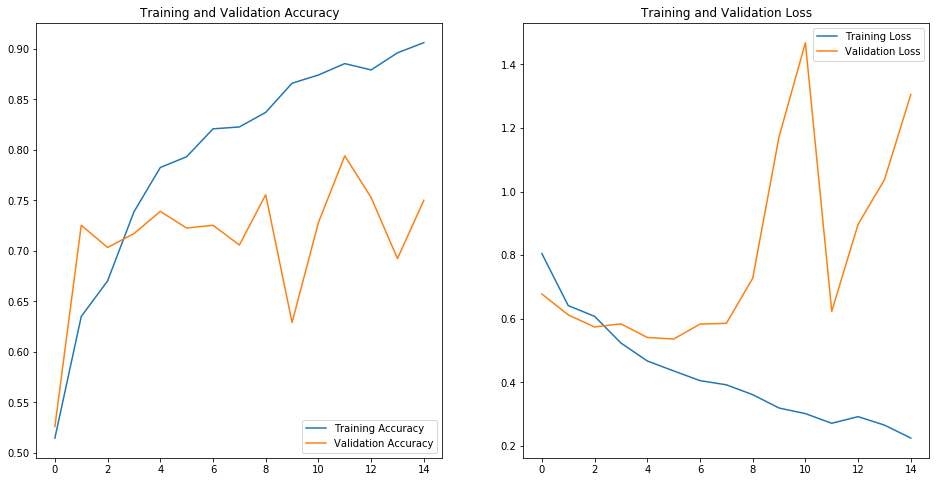

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model performance:
              precision    recall  f1-score   support

         0.0       0.83      0.68      0.75       225
         1.0       0.70      0.84      0.77       203

    accuracy                           0.76       428
   macro avg       0.77      0.76      0.76       428
weighted avg       0.77      0.76      0.76       428



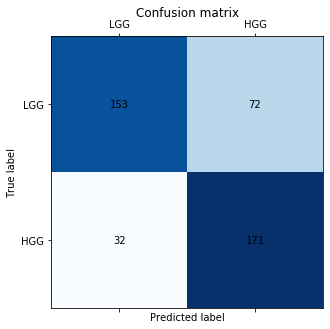

In [16]:
y_true = []
pred = []
iterations = 428 / batch_size
for i, (images, labels) in enumerate(val_data_gen):
    if i > iterations:
        break
    prob = model.predict(images)
    p = prob.argmax(axis=1)
    pred.extend(p)
    y_true.extend(labels)
plots.plot_model_performance(y_true, pred)